# Re-train the model


In this notebook, the model will be retrained daily using the sensor values from the previous day and the actual measured furnace temperature at the end of that day. These new data points will be added to the historical dataset, allowing the model to continuously improve its predictions based on the most recent information. By updating the model regularly, we aim to refine its accuracy over time.

Once the model has been retrained, the two new measurements from the factory sensors for the current day will be injected into the model to predict the optimal furnace temperature by the end of the day. To verify the model's accuracy, the predicted value will be compared to the actual measured temperature at the end of the day, providing a basis for assessing the precision and reliability of the predictions.


The sensor values and the measured temperature from the current day will be added to the historical dataset, so they can be included in the training set for the following day's model retraining.

In [51]:
# Install the model packages
# ==============================================================================
!pip install skforecast feature-engine onnxmltools


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [52]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from feature_engine.timeseries.forecasting import WindowFeatures
from feature_engine.timeseries.forecasting import LagFeatures
from skforecast.datasets import fetch_dataset
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster

# Plots
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# ONNX imports
# ==============================================================================
import os
import onnx
import onnxmltools
from onnxmltools.convert import convert_lightgbm
from onnxmltools.utils import save_model

In [53]:
# Load historical data
# ==============================================================================
data = pd.read_csv('data/historical.csv')

# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

In [54]:
# Select the number of days we want to validate for
# ==============================================================================
steps = 7

Train dates : 1992-04-01 00:00:00 --- 2004-11-01 00:00:00  (n=152)
Test dates  : 2004-12-01 00:00:00 --- 2005-06-01 00:00:00  (n=7)


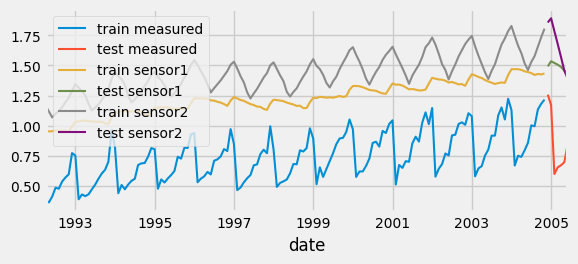

In [55]:
# Split historical data into train-test
# ==============================================================================
data_train = data[:-steps]
data_test = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train measured')
data_test['y'].plot(ax=ax, label='test measured')
data_train['exog_1'].plot(ax=ax, label='train sensor1')
data_test['exog_1'].plot(ax=ax, label='test sensor1')
data_train['exog_2'].plot(ax=ax, label='train sensor2')
data_test['exog_2'].plot(ax=ax, label='test sensor2')
ax.legend(loc='upper left');

In [56]:
# Tune Hyperparameters: grid search train-test
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Candidate values for lags
lags_grid = [10, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 8]
}

cv = TimeSeriesFold(
    steps                 = steps,
    initial_train_size    = int(len(data_train)*0.5),
    fixed_train_size      = False,
    gap                   = 0,
    skip_folds            = None,
    allow_incomplete_fold = True,
    refit                 = False
)

results_grid = grid_search_forecaster(
              forecaster         = forecaster,
              y                  = data_train['y'],
              param_grid         = param_grid,
              lags_grid          = lags_grid,
              cv                 = cv,
              metric             = 'mean_squared_error',
              return_best        = True,
              n_jobs             = 'auto',
              verbose            = False,
              show_progress      = True
)

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 8, 'n_estimators': 250}
  Backtesting metric: 0.026646397540636416


In [57]:
# Search results
# ==============================================================================
results_grid

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 8, 'n_estimators': 250}",0.026646,8,250
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 250}",0.026646,3,250
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 8, 'n_estimators': 100}",0.028957,8,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.028957,3,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'n_estimators': 100}",0.056781,8,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.056781,3,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'n_estimators': 250}",0.060229,8,250
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 250}",0.060229,3,250


In [58]:
# Train the model with the optimal values
# ==============================================================================
forecaster.fit(y=data_train['y'], exog=data_train[['exog_1', 'exog_2']])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Window features: None 
Window size: 20 
Exogenous included: True 
Exogenous names: exog_1, exog_2 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2004-11-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 8,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 250, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-11-27 13:56:13 
Last fit date: 2024-11-27 13:56:32 
Skforecast version: 0.14.0 
Python version: 3.11.7 
Forecaster id: None

In [59]:
# Validation
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])

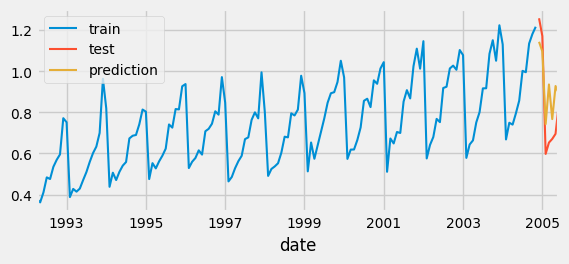

In [60]:
# Plot Validation
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='prediction')
ax.legend();

In [61]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.026498199812788944


In [64]:
# Save the model
# ==============================================================================
regressor = forecaster.regressor

# Define the entry type for ONNX
initial_type = [('float_input', FloatTensorType([None, 20]))]

# Convert the model from LightGBM to ONNX
onnx_model = convert_lightgbm(regressor, name="LGBMRegressor", initial_types=initial_type)

# Save the onnx model
os.makedirs("models/edge/1", exist_ok=True)
save_model(onnx_model, "models/edge/1/model.onnx")

The maximum opset needed by this model is only 8.
